# AirBnb listings file modeling

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import seaborn as sns
import pandas as pd
import math

import sklearn.model_selection as cv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [3]:
# data_path = os.path.join(os.getcwd(), "../data/cleaned_listings.csv")
listings = pd.read_csv("cleaned_listings.csv", index_col="id")
display(listings.shape)

(48855, 65)

### Plot the dstribution

Let's plot the percentile for price

Text(0, 0.5, 'Price')

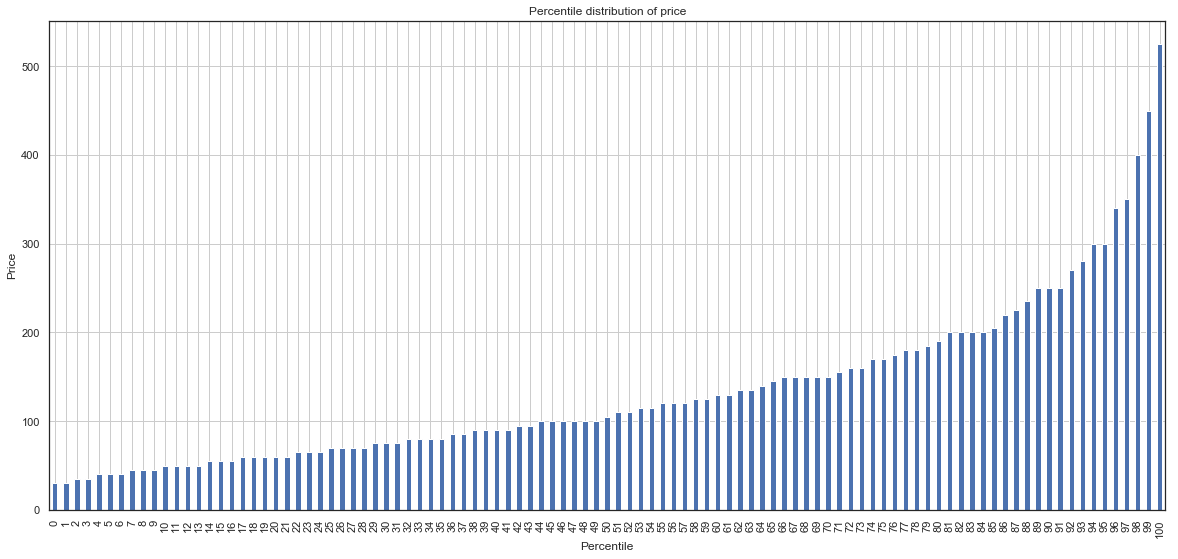

In [4]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

sns.set(style="white")
price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(20,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

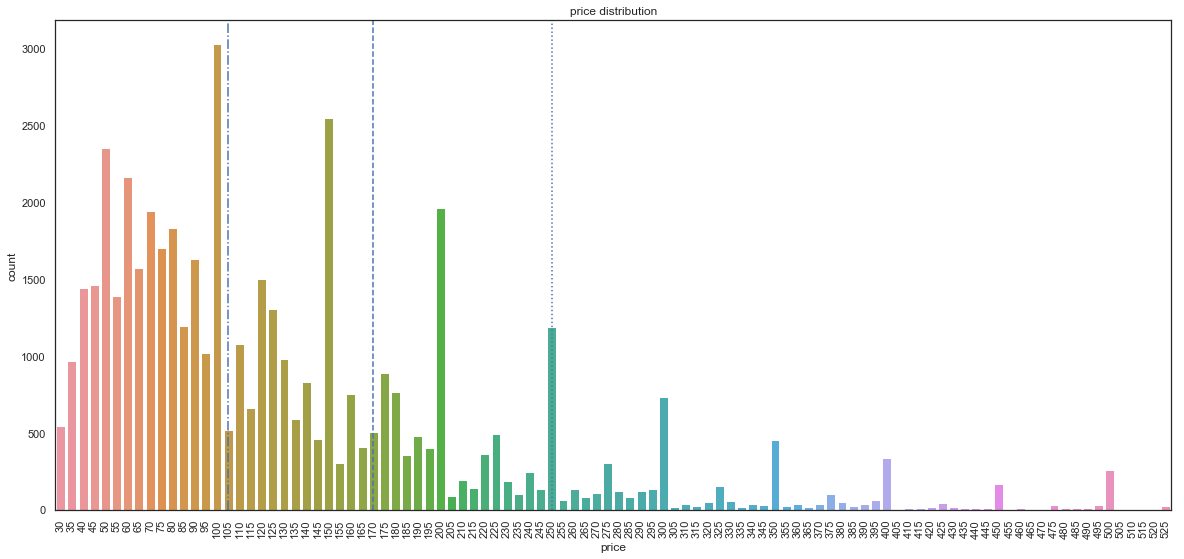

In [5]:
f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.countplot(x="price", data=listings, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")
median_idx = np.where(np.sort(listings["price"].unique())==listings["price"].median())
plt.axvline(x=median_idx, linestyle="-.")
percentile_75_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[75,:].values[0])
plt.axvline(x=percentile_75_idx, linestyle="--")
percentile_90_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[90,:].values[0])
plt.axvline(x=percentile_90_idx, linestyle=":")

------------------

Quick helper functions

In [4]:
def roundto(row, base=5):
    return int(base * round(float(row) / base))

# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

##  Oversampling using SMOTE

In [5]:
def check_rep(row):
    if (row <= 200) | (row==250) | (row==350) | (row==450) | (row==550) :
        return 0
    elif (row > 200) & (row < 300) & (row != 250):
        return 1 
    elif (row > 300) & (row < 400) & (row != 350):
        return 2 
    else:
        return 3 

listings["flag_ur"] = listings["price"].apply(check_rep)

In [6]:
vcs = listings["flag_ur"].value_counts()
vcs

0    43321
1     3093
3     1624
2      817
Name: flag_ur, dtype: int64

In [7]:
ycol = ["flag_ur"]
xcol = [i for i in listings.columns if i not in ycol]

x = listings[xcol].values
y = listings[ycol].values

smote_sampling_strategy = {
    1: int(vcs[1]*2)
    ,2: int(vcs[2]*2)
    ,3: int(vcs[3]*2)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)
# Fit the smote onto the sample
x_new, y_new = sm.fit_sample(x, y)

# Drop the flag column
listings.drop(labels=["flag_ur"], axis=1, inplace=True)

# ---------------------------------------------------------------------------------------------------------
# Overwrite X and Y
price_index = get_index(list(listings.columns), "price")

y = x_new[:, price_index]
x = np.delete(x_new, price_index, axis=1)
for i in range(len(y)):
    y[i] = roundto(y[i])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
print(
    " Old size :", listings.shape, "\n",
    "New size :", x.shape
)

 Old size : (48855, 65) 
 New size : (54389, 64)


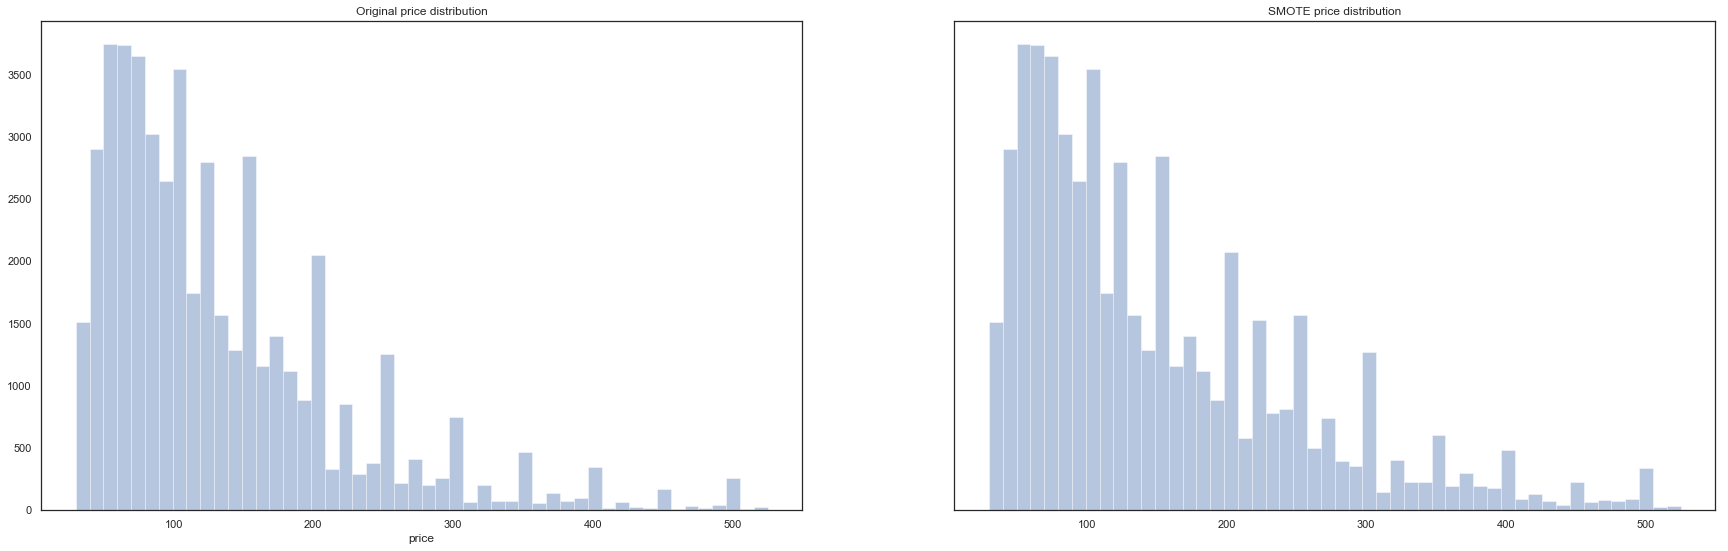

In [11]:
f, ax = plt.subplots(1, 2, figsize=(30, 9), sharey=True)
g1 = sns.distplot(listings["price"], ax=ax[0], kde=False)
t = g1.set_title("Original price distribution")

g2 = sns.distplot(y, ax=ax[1], kde=False)
t = g2.set_title("SMOTE price distribution")


##  Transformation

In [12]:
x_cols = listings.drop(['price'], axis=1)
X = pd.DataFrame(data=x, columns=x_cols.columns)

## Train test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=RANDOM_SEED)

## Standardisation

In [10]:
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

## Prediction

### a. Ridge Regression

In [35]:
# Grid Search
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

rid = Ridge()

parameters = {'alpha': [1e-15, 1e-12, 1e-10, 1e-08, 0.1, 1, 10, 100]}

rid_reg = GridSearchCV(rid, parameters, scoring='neg_mean_squared_error', cv=10)

rid_reg.fit(x_train, y_train)

print(rid_reg.best_params_)

rmse = (-rid_reg.best_score_)**(1/2)
print(rmse)

{'alpha': 1e-08}
64.5309608074011


In [74]:
rid = Ridge(alpha=1e-08)
rid.fit(X=x_train, y=y_train)
y_pred_train = rid.predict(X=x_train)
y_pred_test = rid.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 64.40
Test set RMSE Scaled: 65.17


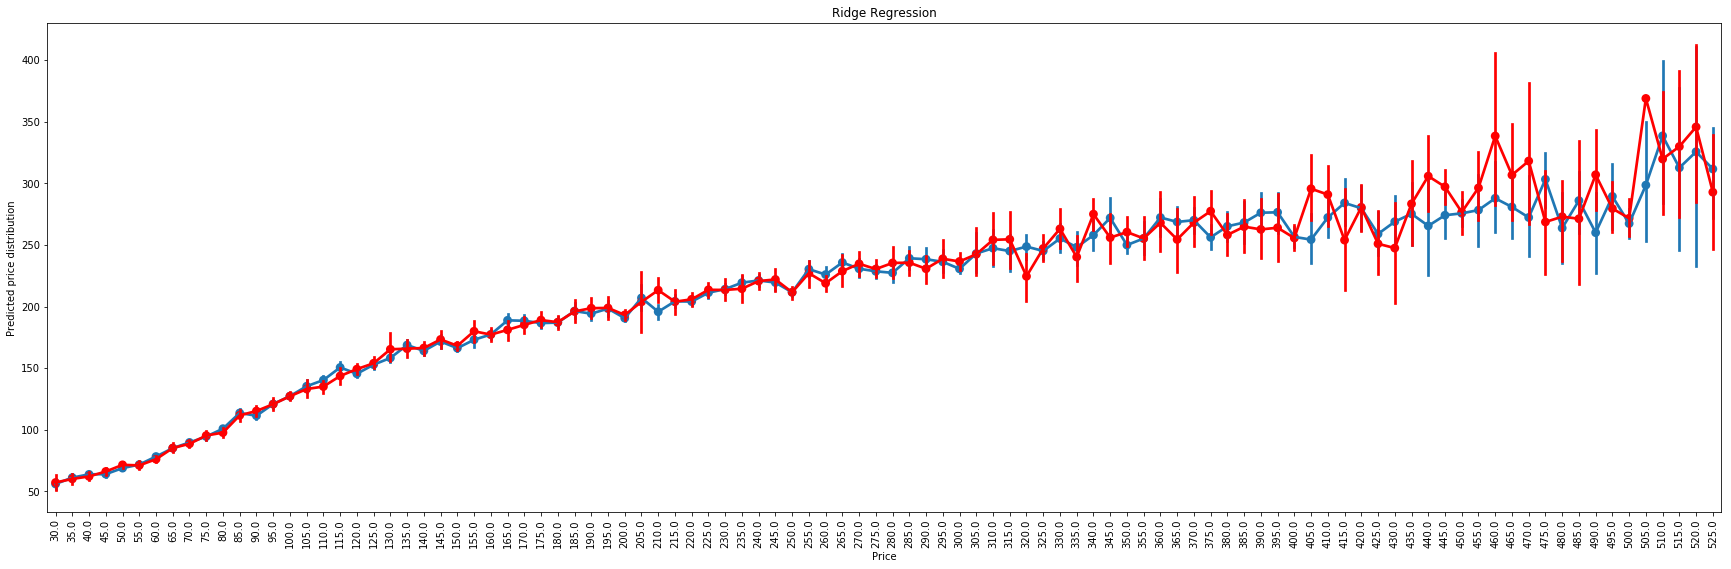

In [75]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Ridge Regression")

In [73]:
th = 200

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 48.04
Test set RMSE Scaled: 49.70


### b. Lasso Regression

In [69]:
# Grid Search
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

las = Lasso()

parameters = {'alpha': [0.15, 0.5, 1]}

las_reg = GridSearchCV(las, parameters, scoring='neg_mean_squared_error', cv=10)

las_reg.fit(x_train, y_train)

print(las_reg.best_params_)

rmse = (-las_reg.best_score_)**(1/2)
print(rmse)

{'alpha': 0.15}
64.58075921581023


In [76]:
las = Lasso(alpha=0.15)
las.fit(X=x_train, y=y_train)
y_pred_train = las.predict(X=x_train)
y_pred_test = las.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 64.46
Test set RMSE Scaled: 64.26


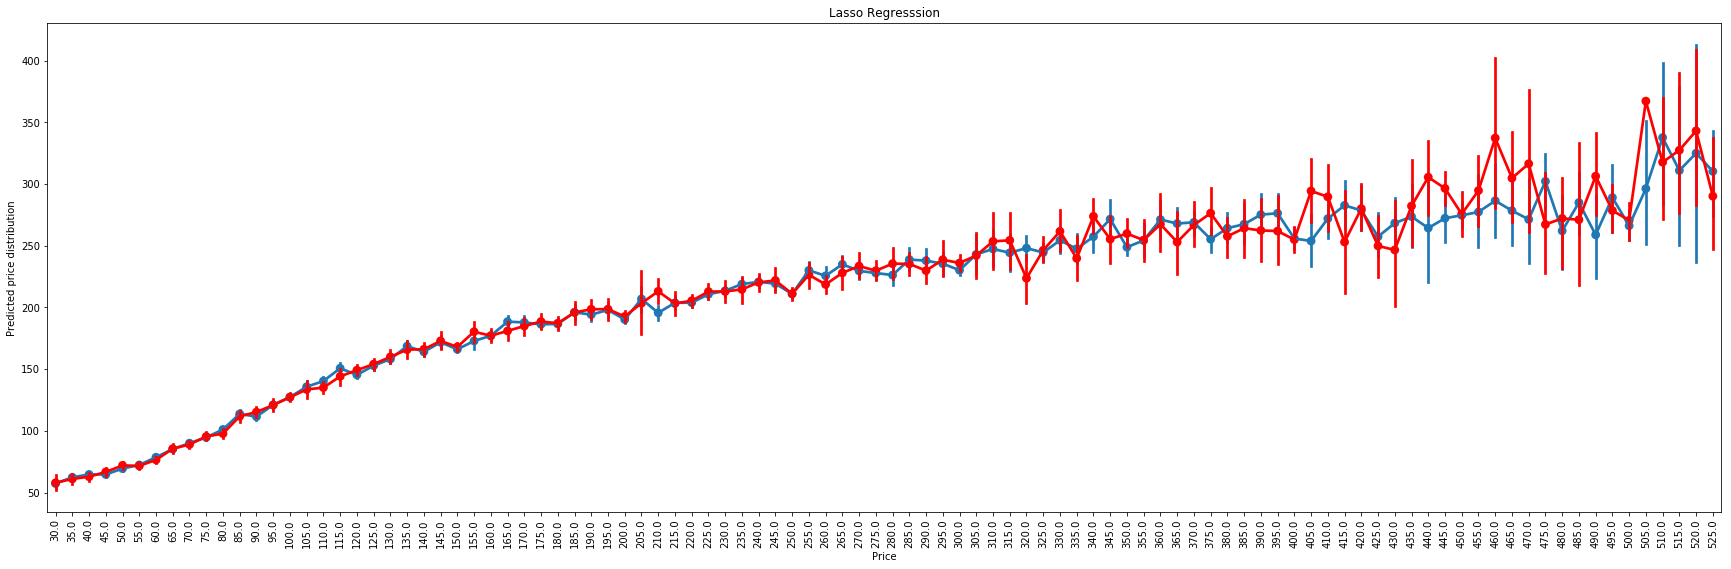

In [77]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Lasso Regresssion")

In [71]:
th = 200

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 47.88
Test set RMSE Scaled: 47.86
